### Concept Validation Experiment

In [1]:
import torch

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"there are {gpu_count} gpu devices.")

    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i + 1}: {gpu_name}")
else:
    print("no gpu found.")


there are 4 gpu devices.
GPU 1: NVIDIA A800-SXM4-80GB
GPU 2: NVIDIA A800-SXM4-80GB
GPU 3: NVIDIA A800-SXM4-80GB
GPU 4: NVIDIA A800-SXM4-80GB


In [2]:
import copy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
# from bert_score import score
import statistics
from ast import literal_eval
import functools
import json
import os
import random
import wget
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
torch.cuda.set_device(2)

random.seed(8888)
torch.manual_seed(8888)
random.seed(8888)
np.random.seed(8888)

if torch.cuda.is_available():
    torch.cuda.manual_seed(8888)
    torch.cuda.manual_seed_all(8888)


from tqdm import tqdm
#from transformers_source.src.transformers.models.llama import LlamaForCausalLM, LlamaTokenizer
from transformers import LlamaForCausalLM, LlamaTokenizer

torch.set_grad_enabled(False)
tqdm.pandas()


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
from os.path import join

# Get CounterFact data for GPT2-xl, from the ROME repository.
#wget.download("https://rome.baulab.info/data/dsets/known_1000.json")


model_dir = "/U_PZL2023ZZ0005/jhyu"
model_name = "Llama-2-7b-chat-hf" 


model = AutoModelForCausalLM.from_pretrained(
    join(model_dir, model_name),
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
);

tokenizer = AutoTokenizer.from_pretrained(join(model_dir, model_name))
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model.to('cuda');


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
model.config

LlamaConfig {
  "_name_or_path": "/U_PZL2023ZZ0005/jhyu/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 32000
}

In [5]:
# Bleu Score Calculation
def calculate_bleu(reference, candidate):
    reference = [reference.split()]
    candidate = candidate.split()
    cc = SmoothingFunction()
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=cc.method3)
    return bleu_score

# Rouge-L Score Calculation
def calculate_rouge_l(reference, candidate):
    try:
        rouge = Rouge()
        scores = rouge.get_scores(candidate, reference)
        rouge_l_score = scores[0]['rouge-l']['f']
        return rouge_l_score
    except:
        return 0.0

# BLEURT-20 Score Calculation
def calculate_bleurt(references, candidates, model, tokenizer, config):

    model.eval()
    with torch.no_grad():
        inputs = tokenizer(references, candidates, padding='longest', return_tensors='pt')
        res = model(**inputs).logits.flatten().tolist()
    print(res)
    return res

    
# Bert-F Score Calculation
def calculate_bert_f(reference, candidate):
    _, _, bert_scores = score([candidate], [reference], lang="en", model_type="bert-base-uncased")
    bert_f_score = bert_scores[0]  # Extracting the F1 score
    return bert_f_score

def add_noise(location, noise_scale = 0):
    # Create Gaussian noise
    mean = 0
    std = noise_scale
    shape = (4096,)
    
    noise = torch.normal(mean, std, size=shape).to('cuda')
    dimension, layer = location[0], location[1]
    global new_params
    if 'llama' in model.config.model_type.lower():
        new_params[f'model.layers.{layer}.mlp.down_proj.weight'][:,dimension] += noise
    elif 'olmo' in model.config.model_type.lower():
        new_params[f'model.transformer.blocks.{layer}.ff_out.weight'][:,dimension] += noise 

def answers_generate(Questions, Questions_unrelated, location, noise = 0):
    answers_list = []
    unrelated_answers_list = []

    if noise != 0:
        add_noise(location = location, noise_scale = noise)
        global old_params, new_params
        model.load_state_dict(new_params)

    len_questions = len(Questions)

    questions = []
    n_new_tokens = 100
    for idx, question in enumerate(Questions + Questions_unrelated):
        questions.append(f"Question: {question}\n Answer:")

    inputs = tokenizer(questions, return_tensors="pt", padding=True, return_token_type_ids=False).to('cuda')
    with torch.no_grad():
        generation_output = model.generate(  # mt.model
            **inputs,
            do_sample=False,
            max_new_tokens=100,
        )
    outputs = tokenizer.batch_decode(generation_output[:, -n_new_tokens:], skip_special_tokens=True)
    answers_list, unrelated_answers_list = outputs[:len_questions], outputs[-len_questions:]   
    assert len(answers_list) == len(unrelated_answers_list)
            
    if noise != 0:
        new_params = old_params
        model.load_state_dict(old_params)

    return answers_list, unrelated_answers_list
    


In [6]:
# Copy model params
global old_params, new_params

old_params = copy.deepcopy(model.state_dict())
new_params = copy.deepcopy(model.state_dict())
#new_params

In [7]:
def random_select_except(lst, n, exclude_index):
    # 排除指定位置的元素
    candidates = [elem for i, elem in enumerate(lst) if i != exclude_index]
    # 从候选元素中随机选择 n 个
    selected = random.sample(candidates, n)
    return selected

**llama validation**

In [8]:
import openpyxl
from openpyxl import Workbook
import re

# 创建一个工作簿
wb = Workbook()
ws = wb.active
# 设置列名
ws.append(["id", "Concept", "Location", "bleu_score", "unrelated_QA_bleu_score", "rouge_l_score","unrelated_QA_rouge_l_score","original_answers","perturbed_answers", "original_unrelated_answers","perturbed_unrelated_answers"])

In [9]:
with open("/home/yihuaihong/Unlearn_Harry_Potter/ConceptMap/ConceptMap_data/llama2-7b_concepts.json", "r", encoding="utf-8") as file:
    concepts_list = json.load(file)

llama_bleu_scores_list = []
llama_rouge_l_scores_list = []
llama_unrelated_bleu_scores_list = []
llama_unrelated_rouge_l_scores_list = []

for idx,concept in enumerate(concepts_list):
    bleu_scores = []
    rouge_l_scores = []
    bert_f_scores = []
    unrelated_bleu_scores = []
    unrelated_rouge_l_scores = []
    unrelated_bert_f_scores = []
    print("idx: ",idx)
    
    dimension, layer = concept['Dim'], concept['Layer']

    concept_name = concept['Concept']
    Questions = concept['QA']

    Questions_unrelated = []

    random_selection = random_select_except(concepts_list, 5, idx)
    
    for selection in random_selection:
        Questions_unrelated += selection['QA']

    concepts_list[idx]['unrelated_QA'] = Questions_unrelated
     
    original_answers, original_unrelated_answers = answers_generate(Questions, Questions_unrelated, noise = 0, location = [dimension, layer])
    perturbed_answers, perturbed_unrelated_answers = answers_generate(Questions, Questions_unrelated, noise = 0.1, location = [dimension, layer])
    #perturbed_answers_big = answers_generate(Questions, noise = 0.3)

    for perturbed_answer, original_answer in zip(perturbed_answers, original_answers):
        bleu_scores.append(calculate_bleu(perturbed_answer, original_answer))
        rouge_l_scores.append(calculate_rouge_l(perturbed_answer, original_answer))
        #bert_f_scores.append(calculate_bert_f(perturbed_answer, original_answer))

   
    for perturbed_unrelated_answer, original_unrelated_answer in zip(perturbed_unrelated_answers, original_unrelated_answers):
        unrelated_bleu_scores.append(calculate_bleu(perturbed_unrelated_answer, original_unrelated_answer))
        unrelated_rouge_l_scores.append(calculate_rouge_l(perturbed_unrelated_answer, original_unrelated_answer))
        #unrelated_bert_f_scores.append(calculate_bert_f(perturbed_unrelated_answer, original_unrelated_answer))
    

    bleu_score = statistics.mean(bleu_scores)  
    rouge_l_score = statistics.mean(rouge_l_scores)  
    
    # bert_f_scores = [tensor.item() for tensor in bert_f_scores]
    # bert_f_score = statistics.mean(bert_f_scores)  

    unrelated_bleu_score = statistics.mean(unrelated_bleu_scores)  
    unrelated_rouge_l_score = statistics.mean(unrelated_rouge_l_scores) 

    # unrelated_bert_f_scores = [tensor.item() for tensor in unrelated_bert_f_scores]
    # unrelated_bert_f_score = statistics.mean(unrelated_bert_f_scores) 


    llama_bleu_scores_list.append(bleu_score)
    llama_rouge_l_scores_list.append(rouge_l_score)
    llama_unrelated_bleu_scores_list.append(unrelated_bleu_score)
    llama_unrelated_rouge_l_scores_list.append(unrelated_rouge_l_score)

    
    
    print(f"Concept: {concept_name} Validation: ", f"bleu_score: {bleu_score} ", f"rouge_l_score: {rouge_l_score} ")
    print(f"Concept: {concept_name} Validation: ", f"unrelated_bleu_score: {unrelated_bleu_score} ", f"unrelated_rouge_l_score: {unrelated_rouge_l_score} ")
    #print(f"Concept: {concept_name} Validation: ", f"bleu_score: {bleu_score} ", f"rouge_l_score: {rouge_l_score} ")
    #print(f"Concept: {concept_name} Validation: ", f"unrelated_bleu_score: {unrelated_bleu_score} ", f"unrelated_rouge_l_score: {unrelated_rouge_l_score} ")
    row_data = [idx, concept_name, bleu_score, unrelated_bleu_score, rouge_l_score, unrelated_rouge_l_score, str(original_answers),str(perturbed_answers), str(original_unrelated_answers),str(perturbed_unrelated_answers)]
    ws.append(row_data)    
 
wb.save("llama2-7b_validation_full.xlsx")    

idx:  0


/home/yihuaihong/anaconda3/envs/harry/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/yihuaihong/anaconda3/envs/harry/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Concept: Golf Validation:  bleu_score: 0.43181490901009933  rouge_l_score: 0.599882767623327 
Concept: Golf Validation:  unrelated_bleu_score: 0.9015168510947723  unrelated_rouge_l_score: 0.9353704353842862 
idx:  1
Concept: Native Americans in the United States Validation:  bleu_score: 0.3879874470533662  rouge_l_score: 0.5877098254282842 
Concept: Native Americans in the United States Validation:  unrelated_bleu_score: 0.8751501373363686  unrelated_rouge_l_score: 0.9191176420607707 
idx:  2
Concept: Martial arts Validation:  bleu_score: 0.21966358504224687  rouge_l_score: 0.4839774367289276 
Concept: Martial arts Validation:  unrelated_bleu_score: 0.9819248627499713  unrelated_rouge_l_score: 0.9851851801851852 
idx:  3
Concept: HTTP cookie Validation:  bleu_score: 0.5162455503644915  rouge_l_score: 0.6860575185477619 
Concept: HTTP cookie Validation:  unrelated_bleu_score: 0.9691884029702291  unrelated_rouge_l_score: 0.9799999950013851 
idx:  4
Concept: Pennsylvania Validation:  bleu

In [10]:
with open("/home/yihuaihong/Unlearn_Harry_Potter/ConceptMap/ConceptMap_data/llama2-7b_concepts_new.json", "w", encoding="utf-8") as test_file:
    json.dump(concepts_list, test_file, ensure_ascii=False, indent=4)

**olmo validation**

In [11]:
del model
del old_params
del new_params
torch.cuda.empty_cache()

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
from os.path import join

# Get CounterFact data for GPT2-xl, from the ROME repository.
#wget.download("https://rome.baulab.info/data/dsets/known_1000.json")


model_dir = "/U_PZL2023ZZ0005/yhhong/transformers"
model_name = "OLMo-7B" 


model = AutoModelForCausalLM.from_pretrained(
    join(model_dir, model_name),
    torch_dtype=torch.float16,
    trust_remote_code=True
);

tokenizer = AutoTokenizer.from_pretrained(join(model_dir, model_name))
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model.to('cuda');


In [13]:
# Copy model params
global old_params, new_params

old_params = copy.deepcopy(model.state_dict())
new_params = copy.deepcopy(model.state_dict())
#new_params

In [14]:
random.seed(8888)
torch.manual_seed(8888)
random.seed(8888)
np.random.seed(8888)

if torch.cuda.is_available():
    torch.cuda.manual_seed(8888)
    torch.cuda.manual_seed_all(8888)

model

OLMoForCausalLM(
  (model): OLMo(
    (transformer): ModuleDict(
      (wte): Embedding(50304, 4096)
      (emb_drop): Dropout(p=0.0, inplace=False)
      (ln_f): LayerNorm()
      (blocks): ModuleList(
        (0-31): 32 x OLMoSequentialBlock(
          (dropout): Dropout(p=0.0, inplace=False)
          (act): SwiGLU()
          (attn_out): Linear(in_features=4096, out_features=4096, bias=False)
          (ff_out): Linear(in_features=11008, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
          (attn_norm): LayerNorm()
          (ff_norm): LayerNorm()
          (att_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (ff_proj): Linear(in_features=4096, out_features=22016, bias=False)
        )
      )
      (ff_out): Linear(in_features=4096, out_features=50304, bias=False)
    )
  )
)

In [15]:
with open("/home/yihuaihong/Unlearn_Harry_Potter/ConceptMap/ConceptMap_data/olmo-7b_concepts.json", "r", encoding="utf-8") as file:
    concepts_list = json.load(file)

olmo_bleu_scores_list = []
olmo_rouge_l_scores_list = []
olmo_unrelated_bleu_scores_list = []
olmo_unrelated_rouge_l_scores_list = []
 
for idx,concept in enumerate(concepts_list):
    bleu_scores = []
    rouge_l_scores = []
    bert_f_scores = []
    unrelated_bleu_scores = []
    unrelated_rouge_l_scores = []
    unrelated_bert_f_scores = []
    print("idx: ",idx)
    
    dimension, layer = concept['Dim'], concept['Layer']

    concept_name = concept['Concept']
    Questions = concept['QA']

    Questions_unrelated = []

    random_selection = random_select_except(concepts_list, 5, idx)
    
    for selection in random_selection:
        Questions_unrelated += selection['QA']

    concepts_list[idx]['unrelated_QA'] = Questions_unrelated
     
    original_answers, original_unrelated_answers = answers_generate(Questions, Questions_unrelated, noise = 0, location = [dimension, layer])
    perturbed_answers, perturbed_unrelated_answers = answers_generate(Questions, Questions_unrelated, noise = 0.1, location = [dimension, layer])
    #perturbed_answers_big = answers_generate(Questions, noise = 0.3)

    for perturbed_answer, original_answer in zip(perturbed_answers, original_answers):
        bleu_scores.append(calculate_bleu(perturbed_answer, original_answer))
        rouge_l_scores.append(calculate_rouge_l(perturbed_answer, original_answer))
        #bert_f_scores.append(calculate_bert_f(perturbed_answer, original_answer))

   
    for perturbed_unrelated_answer, original_unrelated_answer in zip(perturbed_unrelated_answers, original_unrelated_answers):
        unrelated_bleu_scores.append(calculate_bleu(perturbed_unrelated_answer, original_unrelated_answer))
        unrelated_rouge_l_scores.append(calculate_rouge_l(perturbed_unrelated_answer, original_unrelated_answer))
        #unrelated_bert_f_scores.append(calculate_bert_f(perturbed_unrelated_answer, original_unrelated_answer))
    

    bleu_score = statistics.mean(bleu_scores)  
    rouge_l_score = statistics.mean(rouge_l_scores)  
    
    # bert_f_scores = [tensor.item() for tensor in bert_f_scores]
    # bert_f_score = statistics.mean(bert_f_scores)  

    unrelated_bleu_score = statistics.mean(unrelated_bleu_scores)  
    unrelated_rouge_l_score = statistics.mean(unrelated_rouge_l_scores) 

    # unrelated_bert_f_scores = [tensor.item() for tensor in unrelated_bert_f_scores]
    # unrelated_bert_f_score = statistics.mean(unrelated_bert_f_scores) 


    olmo_bleu_scores_list.append(bleu_score)
    olmo_rouge_l_scores_list.append(rouge_l_score)
    olmo_unrelated_bleu_scores_list.append(unrelated_bleu_score)
    olmo_unrelated_rouge_l_scores_list.append(unrelated_rouge_l_score)

    
    
    print(f"Concept: {concept_name} Validation: ", f"bleu_score: {bleu_score} ", f"rouge_l_score: {rouge_l_score} ")
    print(f"Concept: {concept_name} Validation: ", f"unrelated_bleu_score: {unrelated_bleu_score} ", f"unrelated_rouge_l_score: {unrelated_rouge_l_score} ")
    #print(f"Concept: {concept_name} Validation: ", f"bleu_score: {bleu_score} ", f"rouge_l_score: {rouge_l_score} ")
    #print(f"Concept: {concept_name} Validation: ", f"unrelated_bleu_score: {unrelated_bleu_score} ", f"unrelated_rouge_l_score: {unrelated_rouge_l_score} ")
    row_data = [idx, concept_name, bleu_score, unrelated_bleu_score, rouge_l_score, unrelated_rouge_l_score, str(original_answers),str(perturbed_answers), str(original_unrelated_answers),str(perturbed_unrelated_answers)]
    ws.append(row_data)    
 
wb.save("olmo-7b_validation_full.xlsx")    

idx:  0
Concept: Amazon (company) Validation:  bleu_score: 0.501149661185637  rouge_l_score: 0.5964719152234399 
Concept: Amazon (company) Validation:  unrelated_bleu_score: 0.6839574824934773  unrelated_rouge_l_score: 0.7959172951191079 
idx:  1
Concept: Aromatic compound Validation:  bleu_score: 0.13349087699307138  rouge_l_score: 0.3409720159069048 
Concept: Aromatic compound Validation:  unrelated_bleu_score: 0.7351940168670916  unrelated_rouge_l_score: 0.8143628188834143 
idx:  2
Concept: Internet of things Validation:  bleu_score: 0.046309782975777605  rouge_l_score: 0.24445109637100249 
Concept: Internet of things Validation:  unrelated_bleu_score: 0.9337458004031973  unrelated_rouge_l_score: 0.9565217341389415 
idx:  3
Concept: Filmmaking Validation:  bleu_score: 0.701172651206424  rouge_l_score: 0.805044623151973 
Concept: Filmmaking Validation:  unrelated_bleu_score: 0.8979225149101626  unrelated_rouge_l_score: 0.935787446987373 
idx:  4
Concept: Feng shui Validation:  bleu_s

In [17]:
with open("/home/yihuaihong/Unlearn_Harry_Potter/ConceptMap/ConceptMap_data/olmo-7b_concepts_new.json", "w", encoding="utf-8") as test_file:
    json.dump(concepts_list, test_file, ensure_ascii=False, indent=4)

### Plots for Concepts Validation

In [20]:
olmo_bleu_score = statistics.mean(olmo_bleu_scores_list)  
olmo_rouge_l_score = statistics.mean(olmo_rouge_l_scores_list) 
olmo_unrelated_bleu_score = statistics.mean(olmo_unrelated_bleu_scores_list)  
olmo_unrelated_rouge_l_score = statistics.mean(olmo_unrelated_rouge_l_scores_list) 

In [21]:
llama_bleu_score = statistics.mean(llama_bleu_scores_list)  
llama_rouge_l_score = statistics.mean(llama_rouge_l_scores_list) 
llama_unrelated_bleu_score = statistics.mean(llama_unrelated_bleu_scores_list)  
llama_unrelated_rouge_l_score = statistics.mean(llama_unrelated_rouge_l_scores_list) 

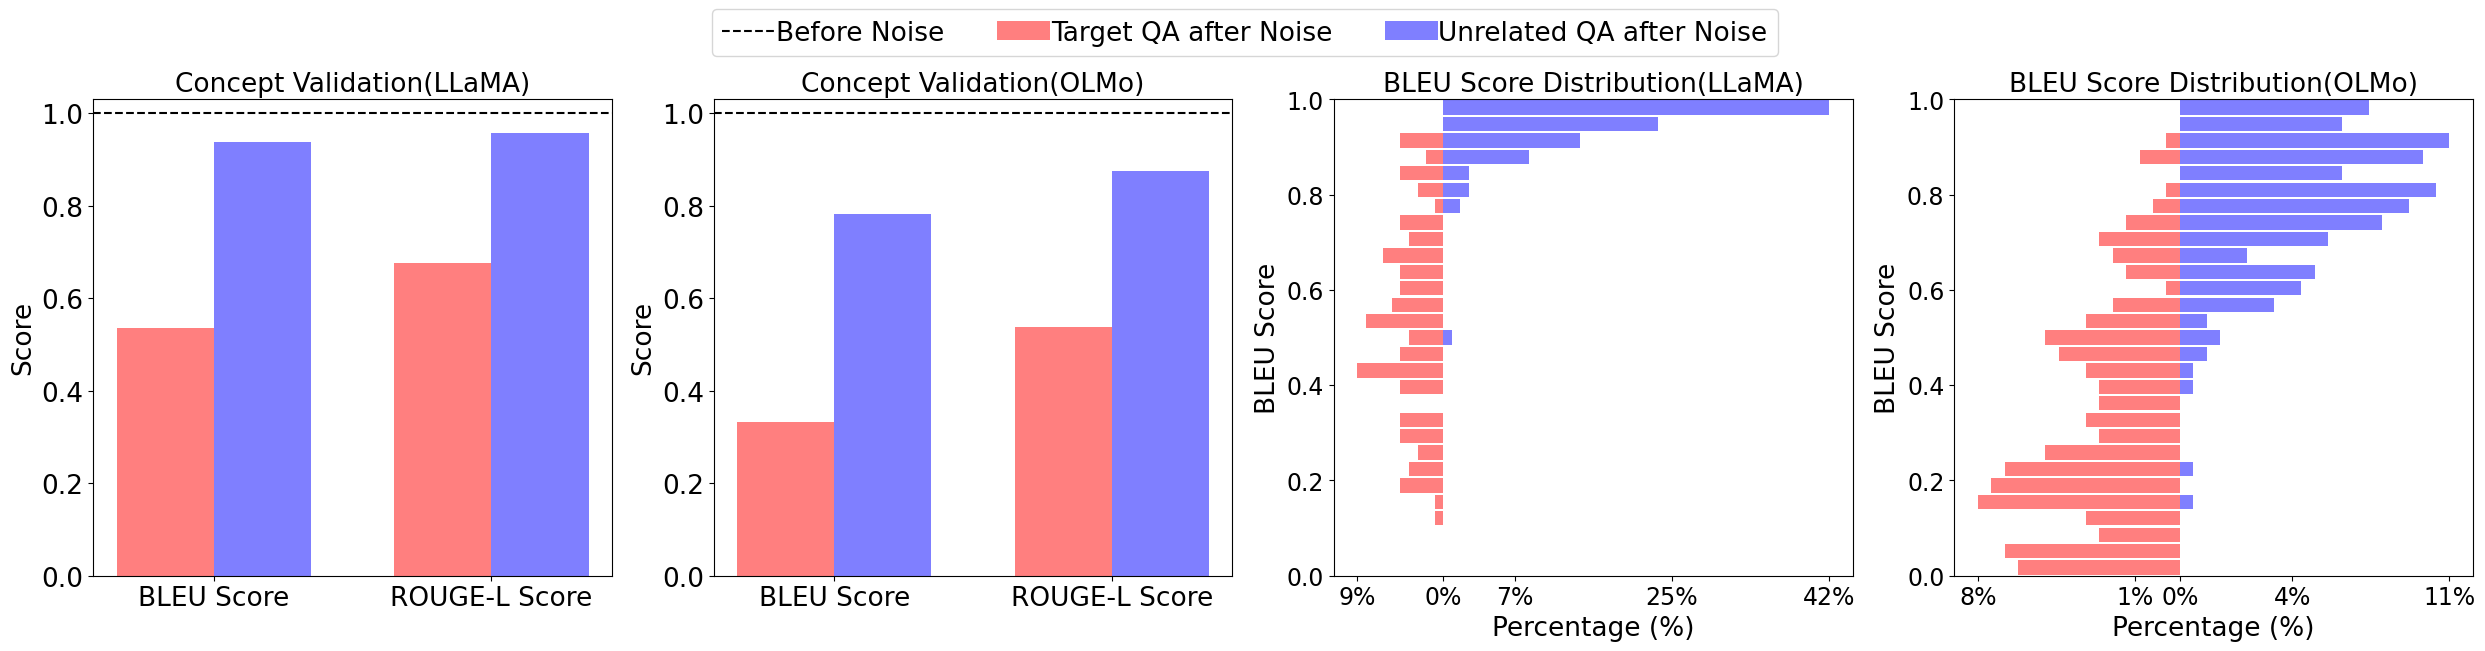

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# 第一、二个图表的数据
datasets = ['BLEU Score', 'ROUGE-L Score']
llama_unrelated_score = [llama_unrelated_bleu_score, llama_unrelated_rouge_l_score] 
llama_score = [llama_bleu_score, llama_rouge_l_score]  

olmo_unrelated_score = [olmo_unrelated_bleu_score, olmo_unrelated_rouge_l_score] 
olmo_score = [olmo_bleu_score, olmo_rouge_l_score]  
n_groups = len(datasets)
index = np.arange(n_groups)
bar_width = 0.35

# 第三、四个图表的数据
llama_bleu_scores_list = [min(score, 0.9) for score in llama_bleu_scores_list]
llama_data_left = llama_bleu_scores_list
llama_data_right = llama_unrelated_bleu_scores_list
bins = np.linspace(0, 1, 30)  # 分30个区间
llama_hist_left, llama_bin_edges_left = np.histogram(llama_data_left, bins=bins)
llama_hist_right, llama_bin_edges_right = np.histogram(llama_data_right, bins=bins)
# 计算百分比
llama_hist_left_percent = llama_hist_left / len(llama_data_left) * 100
llama_hist_right_percent = llama_hist_right / len(llama_data_right) * 100
llama_bin_centers_left = (llama_bin_edges_left[:-1] + llama_bin_edges_left[1:]) / 2
llama_bin_centers_right = (llama_bin_edges_right[:-1] + llama_bin_edges_right[1:]) / 2


olmo_data_left = olmo_bleu_scores_list
olmo_data_right = olmo_unrelated_bleu_scores_list
bins = np.linspace(0, 1, 30)  # 分30个区间
olmo_hist_left, olmo_bin_edges_left = np.histogram(olmo_data_left, bins=bins)
olmo_hist_right, olmo_bin_edges_right = np.histogram(olmo_data_right, bins=bins)
# 计算百分比
olmo_hist_left_percent = olmo_hist_left / len(olmo_data_left) * 100
olmo_hist_right_percent = olmo_hist_right / len(olmo_data_right) * 100
olmo_bin_centers_left = (olmo_bin_edges_left[:-1] + olmo_bin_edges_left[1:]) / 2
olmo_bin_centers_right = (olmo_bin_edges_right[:-1] + olmo_bin_edges_right[1:]) / 2

# 创建子图
fig, axs = plt.subplots(1, 4, figsize=(25, 6))

# 第一个图
ax1 = axs[0]
rects1_ax1 = ax1.bar(index, llama_score, bar_width, color='#FF7F7F', label='Target QA after Noise')
rects2_ax1 = ax1.bar(index + bar_width, llama_unrelated_score, bar_width, color='#7F7FFF',  label='Unrelated QA after Noise') #hatch='//',
ax1.axhline(y=1.00, color='k', linestyle='--', label='Before Noise')
ax1.set_ylabel('Score', fontsize=19)
ax1.set_title('Concept Validation(LLaMA)', fontsize=19)
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(datasets, fontsize=19)
ax1.set_ylim(0, 1.03)
ax1.tick_params(axis='both', which='major', labelsize=19)

# 第二个图
ax2 = axs[1]
rects1_ax2 = ax2.bar(index, olmo_score, bar_width, color='#FF7F7F', label='Target QA')
rects2_ax2 = ax2.bar(index + bar_width, olmo_unrelated_score, bar_width, color='#7F7FFF',  label='Unrelated QA') #hatch='//',
ax2.axhline(y=1.00, color='k', linestyle='--', label='Before Noise')
ax2.set_ylabel('Score', fontsize=19)
ax2.set_title('Concept Validation(OLMo)', fontsize=19)
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(datasets, fontsize=19)
ax2.set_ylim(0, 1.03)
ax2.tick_params(axis='both', which='major', labelsize=19)

# 第三个图
ax3 = axs[2]
ax3.barh(llama_bin_centers_left, -llama_hist_left_percent, height=0.03, alpha=0.5, color='red', label='Left Data')
ax3.barh(llama_bin_centers_right, llama_hist_right_percent, height=0.03, alpha=0.5, color='blue', label='Right Data')
xticks = np.linspace(-llama_hist_left_percent.max(), max(llama_hist_left_percent.max(), llama_hist_right_percent.max()), 4)
xticks = np.unique(np.append(xticks, 0))
# num_ticks = 5
# max_percent = max(llama_hist_left_percent.max(), llama_hist_right_percent.max())
# tick_step = max_percent / (num_ticks // 2)
# xticks = np.arange(-tick_step * (num_ticks // 2), tick_step * (num_ticks // 2) + tick_step, tick_step)


ax3.set_xticks(xticks)
ax3.set_xticklabels([f'{abs(int(tick))}%' for tick in xticks])
ax3.set_title('BLEU Score Distribution(LLaMA)', fontsize=19)
ax3.set_xlabel('Percentage (%)', fontsize=19)
ax3.set_ylabel('BLEU Score', fontsize=19)
ax3.set_ylim(0, 1.)
ax3.tick_params(axis='both', which='major', labelsize=17)


# 第四个图
ax4 = axs[3]
ax4.barh(olmo_bin_centers_left, -olmo_hist_left_percent, height=0.03, alpha=0.5, color='red', label='Left Data')
ax4.barh(olmo_bin_centers_right, olmo_hist_right_percent, height=0.03, alpha=0.5, color='blue', label='Right Data')
xticks = np.linspace(-olmo_hist_left_percent.max(), max(olmo_hist_left_percent.max(), olmo_hist_right_percent.max()), 4)
xticks = np.unique(np.append(xticks, 0))

# num_ticks = 5
# max_percent = max(olmo_hist_left_percent.max(), olmo_hist_right_percent.max())
# tick_step = max_percent / (num_ticks // 2)
# xticks = np.arange(-tick_step * (num_ticks // 2), tick_step * (num_ticks // 2) + tick_step, tick_step)


ax4.set_xticks(xticks)
ax4.set_xticklabels([f'{abs(int(tick))}%' for tick in xticks])
ax4.set_title('BLEU Score Distribution(OLMo)', fontsize=19)
ax4.set_xlabel('Percentage (%)', fontsize=19)
ax4.set_ylabel('BLEU Score', fontsize=19)
ax4.set_ylim(0, 1.)
ax4.tick_params(axis='both', which='major', labelsize=17)

# 设置图例
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=19, ncol=4, bbox_to_anchor=(0.5, 1.10), handletextpad=0.03)
plt.savefig('concept validation experiments.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()

plt.show()
